In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set
trip_temps = calc_temps('2017-08-01', '2017-08-07')

# create dataframe with calculations from above
df_trip_temps = pd.DataFrame(trip_temps, columns=['min', 'avg', 'max'])

# display dataframe
df_trip_temps

,min,avg,max
0,72.0,79.25,83.0


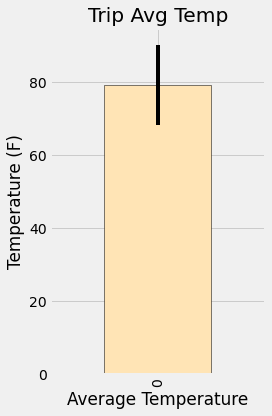

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df_trip_temps['avg'].plot(kind='bar',
                          figsize=(4,6),
                          yerr=(df_trip_temps['max']-df_trip_temps['min']),
                          color='moccasin',
                          edgecolor='black',
                          xlabel='Average Temperature',
                          ylabel="Temperature (F)",
                          title="Trip Avg Temp")

# display bar chart
plt.tight_layout()

# save bar chart
plt.savefig("Images/Trip Avg Temp.png")

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= '2017-08-01').\
    filter(Measurement.date <= '2017-08-07').\
    order_by(func.sum(Measurement.prcp).desc()).all()

# create dataframe with query from above
df_total_rainfall = pd.DataFrame(total_rainfall, columns=['Station', 'Name', 'Latitude', 'Longitdue', 'Elevation', 'Prcp Sum'])

# display dataframe
df_total_rainfall

,Station,Name,Latitude,Longitdue,Elevation,Prcp Sum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
date_list = [date.strftime("%m-%d") for date in date_range]

# Use the `daily_normals` function to calculate the normals for each date string and append the results to a list called `normals`.
normals = []
for date in date_list:
    normals.append(daily_normals(date)[0])
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_trip_normals = pd.DataFrame(normals, columns=['min', 'avg', 'max'], index=date_list)
df_trip_normals

,min,avg,max
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


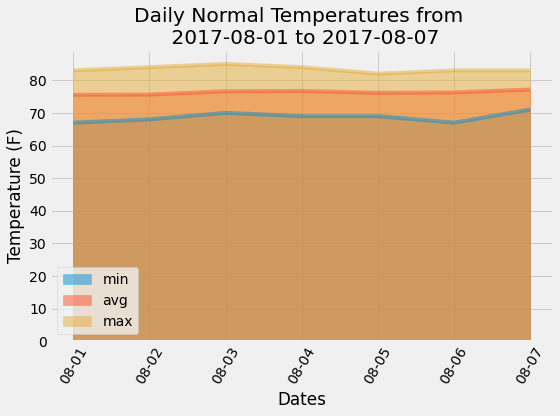

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
df_trip_normals.plot(kind="area",
                     figsize=(8,6),
                     stacked=False,
                     rot=60,
                     xlabel="Dates",
                     ylabel="Temperature (F)",
                     title=f"Daily Normal Temperatures from \n {start_date} to {end_date}")
# display area plot
plt.tight_layout()

# save area plot
plt.savefig("Images/Daily_Normals.png")

## Close Session

In [17]:
session.close()